# Goal
Explore some normalization methods for stream gauge data

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("/home/nick/C2S-Python-API/")
import os
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import rasterio
import dataretrieval.nwis as nwis # If missing install with !pip install dataretrieval
import time
from c2s.credentials import get_gcsfs

In [5]:
fs = get_gcsfs()

# Fetch data
Working daily values for speed and convenience, but could just as easily work with the instantaneous values

In [6]:
with fs.open(f"gs://streamgauge_data/all_stream_gauges_dv_2023_08_10.geojson", 'r') as f:
    df_streamgauges_dv = gpd.read_file(f)

In [9]:
df_streamgauges_dv.columns.tolist()

['agency_cd',
 'site_no',
 'station_nm',
 'site_tp_cd',
 'dec_lat_va',
 'dec_long_va',
 'coord_acy_cd',
 'dec_coord_datum_cd',
 'alt_va',
 'alt_acy_va',
 'alt_datum_cd',
 'huc_cd',
 'data_type_cd',
 'parm_cd',
 'stat_cd',
 'ts_id',
 'loc_web_ds',
 'medium_grp_cd',
 'parm_grp_cd',
 'srs_id',
 'access_cd',
 'begin_date',
 'end_date',
 'count_nu',
 'years_of_history',
 'state_code',
 'geometry']

Let's somewhat arbitrarily just use all of the stream gauges in Vermont

In [10]:
df_streamgauges_dv.loc[df_streamgauges_dv["state_code"] == "VT", :]

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,...,medium_grp_cd,parm_grp_cd,srs_id,access_cd,begin_date,end_date,count_nu,years_of_history,state_code,geometry
34572,USGS,01133000,"EAST BRANCH PASSUMPSIC RIVER NEAR EAST HAVEN, VT",ST,44.633942,-71.897594,S,NAD83,943.34,0.21,...,wat,None,1645423,0,1939-07-09,2023-08-14,23078,84.156164,VT,POINT (-71.89759 44.63394)
34573,USGS,01133500,"PASSUMPSIC R @ PIERCE'S MILLS, NR ST JOHNSBURY...",ST,44.486168,-72.009262,S,NAD83,580.00,20.00,...,wat,None,1645423,0,1909-05-26,1919-07-24,3242,10.167123,VT,POINT (-72.00926 44.48617)
34574,USGS,01134500,"MOOSE RIVER AT VICTORY, VT",ST,44.511723,-71.837314,S,NAD83,1103.46,0.16,...,wat,None,1645423,0,1947-01-01,2023-08-14,27985,76.668493,VT,POINT (-71.83731 44.51172)
34575,USGS,01134800,"KIRBY BROOK AT CONCORD, VT",ST,44.441725,-71.878426,S,NAD83,920.00,20.00,...,wat,None,1645423,0,1963-06-20,1974-09-30,4121,11.287671,VT,POINT (-71.87843 44.44172)
34576,USGS,01135000,"MOOSE RIVER AT ST. JOHNSBURY, VT",ST,44.422836,-72.000094,S,NAD83,585.00,20.00,...,wat,None,1645423,0,1928-08-07,1983-09-30,20143,55.183562,VT,POINT (-72.00009 44.42284)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34682,USGS,04294300,"PIKE RIVER AT EAST FRANKLIN, NR ENOSBURG FALLS...",ST,45.002822,-72.833469,S,NAD83,397.54,0.13,...,wat,None,1645423,0,2001-08-03,2023-08-14,8043,22.043836,VT,POINT (-72.83347 45.00282)
34683,USGS,04296000,"BLACK RIVER AT COVENTRY, VT",ST,44.868936,-72.270104,S,NAD83,709.74,0.10,...,wat,None,1645423,0,1951-10-01,2023-08-14,26240,71.917808,VT,POINT (-72.27010 44.86894)
34684,USGS,04296200,"BROWNINGTON BRANCH NEAR EVANSVILLE, VT",ST,44.833382,-72.065932,S,NAD83,1170.00,20.00,...,wat,None,1645423,0,1963-06-20,1973-12-31,3848,10.539726,VT,POINT (-72.06593 44.83338)
34685,USGS,04296280,"BARTON RIVER NEAR COVENTRY, VT",ST,44.871389,-72.200556,S,NAD83,679.69,0.10,...,wat,None,1645423,0,2010-07-16,2023-08-14,4777,13.087671,VT,POINT (-72.20056 44.87139)


<AxesSubplot:>

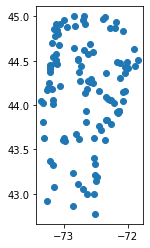

In [16]:
df_streamgauges_dv.loc[df_streamgauges_dv["state_code"] == "VT", :].plot()

In [30]:
site_nums = df_streamgauges_dv.loc[df_streamgauges_dv["state_code"] == "VT", "site_no"].tolist()

In [31]:
site_nums

['01133000',
 '01133500',
 '01134500',
 '01134800',
 '01135000',
 '01135100',
 '01135150',
 '01135300',
 '01135500',
 '01136000',
 '01138500',
 '01139000',
 '01139500',
 '01139800',
 '01139830',
 '01139833',
 '01139838',
 '01140000',
 '01140570',
 '01140575',
 '01140580',
 '01140590',
 '01140600',
 '01140817',
 '01140820',
 '01141500',
 '01142000',
 '01142500',
 '01143500',
 '01144000',
 '01150800',
 '01150900',
 '01151000',
 '01151500',
 '01152800',
 '01153000',
 '01153500',
 '01153550',
 '01154000',
 '01155200',
 '01155300',
 '01155500',
 '01155910',
 '01156000',
 '01156500',
 '01167800',
 '01329000',
 '01334000',
 '04280000',
 '04280300',
 '04280350',
 '04280800',
 '04280910',
 '04281500',
 '04282000',
 '04282500',
 '04282525',
 '04282576',
 '04282581',
 '04282586',
 '04282629',
 '04282650',
 '04282700',
 '04282780',
 '04282795',
 '04282800',
 '04282805',
 '04282813',
 '04282815',
 '04283000',
 '04284000',
 '04284751',
 '04285500',
 '04285800',
 '04286000',
 '04286500',
 '04287000',

## Get single-day discharge values

In [33]:
# get the DV values for a particular day
dv_gdf, _ = nwis.get_dv(
    sites=site_nums, 
    parameterCd="00060", 
    start="2023-05-01", 
    end="2023-05-01",
)
dv_gdf

,,00060_Mean,00060_Mean_cd
site_no,datetime,,
01133000,2023-05-01 00:00:00+00:00,372.00,A
01134500,2023-05-01 00:00:00+00:00,397.00,P
01135100,2023-05-01 00:00:00+00:00,1.33,P
01135150,2023-05-01 00:00:00+00:00,28.80,P
01135300,2023-05-01 00:00:00+00:00,307.00,A
01135500,2023-05-01 00:00:00+00:00,2060.00,P
01138500,2023-05-01 00:00:00+00:00,10500.00,P
01139000,2023-05-01 00:00:00+00:00,739.00,P
01139800,2023-05-01 00:00:00+00:00,106.00,P


## Get stats for test gauges

In [36]:
# get the DV values for a particular day
daily_stats = nwis.get_stats(
    sites=site_nums, statTypeCd="all",
)
daily_stats

ValueError: Bad Request, check that your parameters are correct. URL: https://waterservices.usgs.gov/nwis/stat?sites=01133000%2C01133500%2C01134500%2C01134800%2C01135000%2C01135100%2C01135150%2C01135300%2C01135500%2C01136000%2C01138500%2C01139000%2C01139500%2C01139800%2C01139830%2C01139833%2C01139838%2C01140000%2C01140570%2C01140575%2C01140580%2C01140590%2C01140600%2C01140817%2C01140820%2C01141500%2C01142000%2C01142500%2C01143500%2C01144000%2C01150800%2C01150900%2C01151000%2C01151500%2C01152800%2C01153000%2C01153500%2C01153550%2C01154000%2C01155200%2C01155300%2C01155500%2C01155910%2C01156000%2C01156500%2C01167800%2C01329000%2C01334000%2C04280000%2C04280300%2C04280350%2C04280800%2C04280910%2C04281500%2C04282000%2C04282500%2C04282525%2C04282576%2C04282581%2C04282586%2C04282629%2C04282650%2C04282700%2C04282780%2C04282795%2C04282800%2C04282805%2C04282813%2C04282815%2C04283000%2C04284000%2C04284751%2C04285500%2C04285800%2C04286000%2C04286500%2C04287000%2C04287300%2C04288000%2C04288225%2C04288230%2C04288295%2C04289000%2C04290335%2C04290500%2C04290575%2C04290580%2C04290610%2C04291000%2C04291500%2C04292000%2C04292100%2C04292201%2C04292500%2C04292700%2C04292750%2C04292770%2C04292795%2C04292800%2C04292810%2C04293000%2C04293200%2C04293430%2C04293500%2C04293600%2C04293700%2C04293795%2C04293900%2C04294000%2C04294140%2C04294300%2C04296000%2C04296200%2C04296280%2C04296500&statTypeCd=all&format=rdb

# Developing normalization methods

## Method 1: divide by median discharge